Install the necassary packages

In [2]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install av

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import the necassary stuff

In [1]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import cv2
from PIL import Image
import numpy as np
from torchvision.io.video import read_video, write_video
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

ModuleNotFoundError: ignored

In [ ]:
plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [4]:
input_video, _, info = read_video("cat_original.mp4", pts_unit="sec", output_format="TCHW")
# input_video = input_video.div(255)

In [ ]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

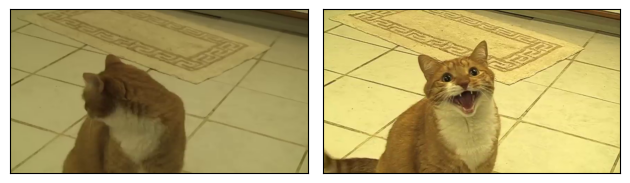

In [ ]:
img1_batch = torch.stack([input_video[1], input_video[15]])
plot(img1_batch)

Get the canny edges:

In [ ]:
image = input_video[15]
image = image.permute(1, 2, 0)

print(image.shape)

image = np.array(image)

low_threshold = 100
high_threshold = 200

print(image.shape)

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

torch.Size([470, 854, 3])
(470, 854, 3)


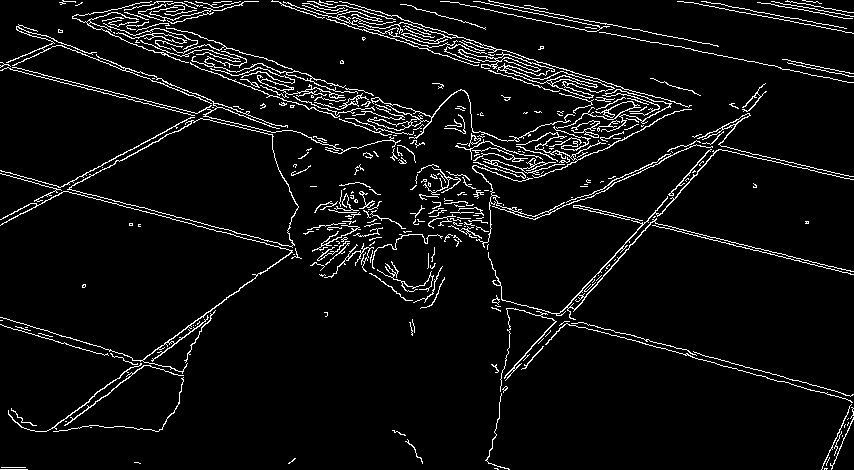

In [ ]:
canny_image

Now let's do the style transfer

  0%|          | 0/20 [00:00<?, ?it/s]

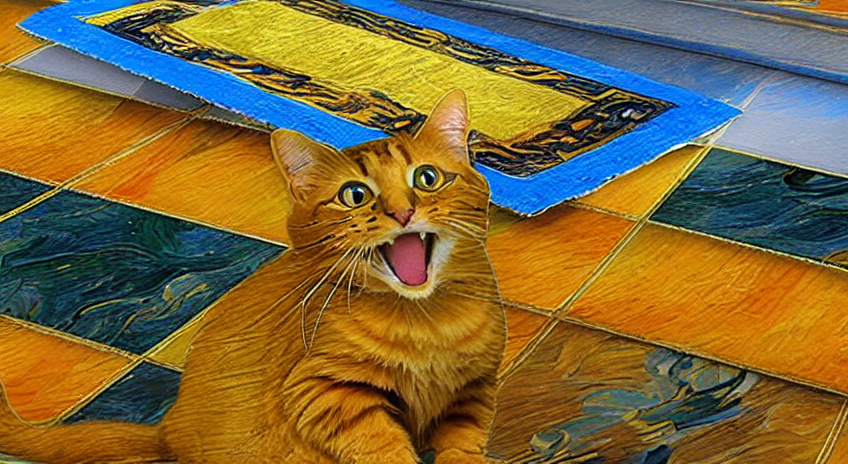

In [ ]:
prompt = "Yellow cat in van gogh style"
generator = torch.Generator(device="cuda").manual_seed(42)

output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy",
    generator=generator,
    num_inference_steps=20,
)
output[0][0]

In [ ]:
prompt = "Yellow cat in van gogh style"
output_video = []
generator = torch.Generator(device="cuda").manual_seed(42)

for i in range(0, len(input_video)):
  image = input_video[i]
  image = image.permute(1, 2, 0)

  image = np.array(image)

  low_threshold = 100
  high_threshold = 200

  image = cv2.Canny(image, low_threshold, high_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)
  canny_image = Image.fromarray(image)

  output = pipe(
      prompt,
      canny_image,
      negative_prompt="monochrome, lowres, bad anatomy",
      generator=generator,
      num_inference_steps=20,
  )
  output_video.append(output[0][0])


NameError: ignored

In [ ]:
output_video_pytorch = []

for frame in output_video:
  img = frame
  img_array = np.array(img)
  tensor = torch.from_numpy(img_array)
  output_video_pytorch.append(tensor)

output_video_pytorch = torch.stack(output_video_pytorch)
print(output_video_pytorch.shape)
write_video("Cat_vanGogh.mp4", output_video_pytorch, fps=info["video_fps"])

RuntimeError: ignored

# Hed controlnet

In [3]:
!pip install -q controlnet_aux==0.0.5
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 52.8 MB/s eta 0:00:00


In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import cv2
from PIL import Image
import numpy as np
from torchvision.io.video import read_video, write_video
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from controlnet_aux import HEDdetector

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [14]:
input_video, _, info = read_video("cat_original.mp4", pts_unit="sec", output_format="TCHW")
image = input_video[20]
image = image.permute(1, 2, 0)
print(image.shape)


hed = HEDdetector.from_pretrained('lllyasviel/Annotators')

torch.Size([470, 854, 3])


In [2]:
image_HED = hed(image)
image_HED

NameError: ignored

In [16]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

image = pipe("Van gogh painting of a cat, masterpiece", image_HED, num_inference_steps=20).images[0]


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

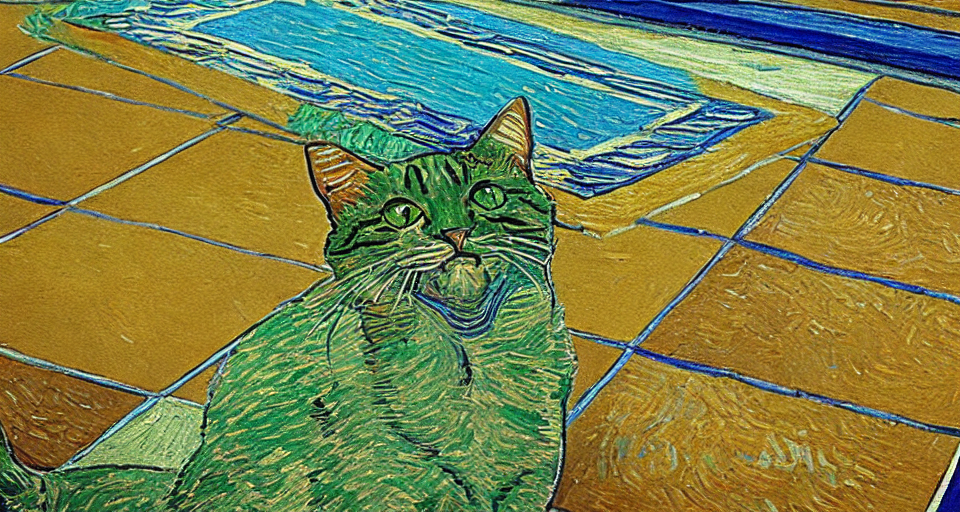

In [17]:
image = pipe("Van gogh painting of a cat, masterpiece", image_HED, num_inference_steps=20).images[0]
image

In [18]:
prompt = "Van gogh painting of a cat, masterpiece"
output_video = []
generator = torch.Generator(device="cuda").manual_seed(42)

for i in range(0, len(input_video)):
  image = input_video[i]
  image = image.permute(1, 2, 0)
  hed = HEDdetector.from_pretrained('lllyasviel/Annotators')
  image_HED = hed(image)
  image = pipe("Van gogh painting of a cat, masterpiece", image_HED, num_inference_steps=20).images[0]
  output_video.append(image)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
output_video_pytorch = []

for frame in output_video:
  img = frame
  img_array = np.array(img)
  tensor = torch.from_numpy(img_array)
  output_video_pytorch.append(tensor)

output_video_pytorch = torch.stack(output_video_pytorch)
print(output_video_pytorch.shape)
write_video("Cat_vanGogh.mp4", output_video_pytorch, fps=info["video_fps"])

torch.Size([28, 512, 960, 3])


# Hed controlnet + color conditioning

In [1]:
# !pip install -q controlnet_aux==0.0.5
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install av

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import cv2
from PIL import Image
import numpy as np
from torchvision.io.video import read_video, write_video
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from controlnet_aux import HEDdetector

In [5]:
torch.cuda.empty_cache()

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16
)

temporalNet = ControlNetModel.from_pretrained("CiaraRowles/TemporalNet", torch_dtype=torch.float16)

hed_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
).to("cuda")
hed_pipe.scheduler = UniPCMultistepScheduler.from_config(hed_pipe.scheduler.config)
hed_pipe.enable_xformers_memory_efficient_attention()
hed_pipe.enable_model_cpu_offload()

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=[controlnet, temporalNet], safety_checker=None, torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()



unet\diffusion_pytorch_model.safetensors not found
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
unet\diffusion_pytorch_model.safetensors not found
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do

In [15]:
input_video, _, info = read_video("Input/DYVid.mp4", pts_unit="sec", output_format="TCHW")
initialframe = input_video[0]
image = initialframe
image = image.permute(1, 2, 0)


hed = HEDdetector.from_pretrained('lllyasviel/Annotators')
image_HED = hed(image)

  0%|          | 0/20 [00:00<?, ?it/s]

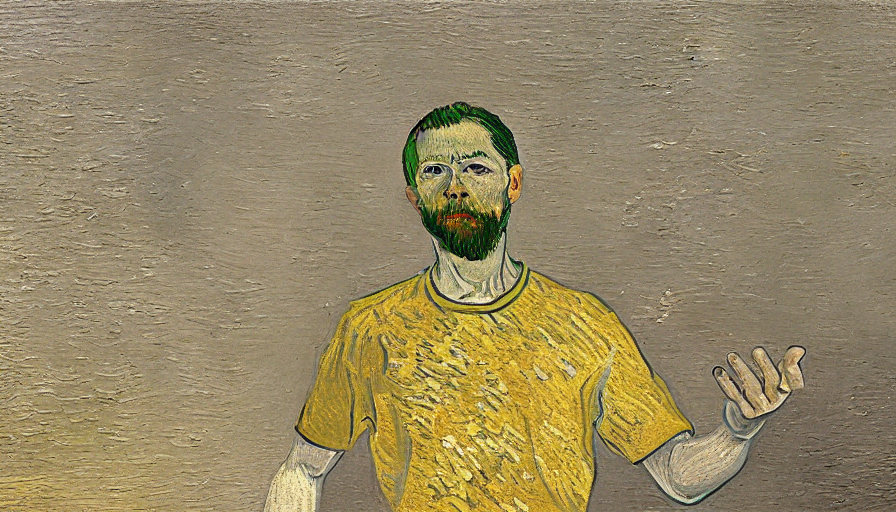

In [16]:
initial_image_transformed = hed_pipe("Van gogh painting of a man, masterpiece", image_HED, num_inference_steps=20).images[0]
initial_image_transformed

In [23]:
secondframe = input_video[1]
secondframe = F.to_pil_image(secondframe)


image2 = initial_image_transformed
# image2 = image2.permute(1, 2, 0)

image_HED2 = hed(image2)

In [24]:
print(image_HED2.size)
# Add a new dimension at the beginning of the tensor
#image2 = torch.unsqueeze(image2, 0)
print(image2.size)

(896, 512)
(896, 512)


In [25]:
image2_transformed = pipe(["Van gogh painting of a man, masterpiece"]*2, [secondframe, initial_image_transformed], num_inference_steps=20).images[0]

You have 2 ControlNets and you have passed 2 prompts. The conditionings will be fixed across the prompts.


  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 318.00 MiB (GPU 0; 6.00 GiB total capacity; 4.57 GiB already allocated; 0 bytes free; 5.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
print(image_HED.size)
print(image.shape)


# Convert PIL image to NumPy array
image_array = np.array(image_HED)

# Repeat the image along the third axis
repeated_image_array = np.repeat(image_array[:, :], 1, axis=2)

# Convert NumPy array to torch tensor
torch_tensor = torch.from_numpy(repeated_image_array)

# Transpose the tensor to get the correct dimensions
image_HED_torch = torch.transpose(torch_tensor, 0, 1)


print(image_HED_torch.shape)

(896, 512)
torch.Size([2160, 3840, 3])
torch.Size([896, 512, 3])


In [31]:
initial_image = pipe(["Van gogh painting of a cat, masterpiece"]*2, [image, image_HED], num_inference_steps=20).images[0]

You have 2 ControlNets and you have passed 2 prompts. The conditionings will be fixed across the prompts.


ValueError: If image batch size is not 1, image batch size must be same as prompt batch size. image batch size: 2160, prompt batch size: 2